# An image is worth 16$\times$16 words: Transformers for image recognition at scale

https://arxiv.org/abs/2010.11929

"A pure transformer applied directly to sequence of image patches can perform very well on image classification tasks."

![](https://github.com/yongbinkim-chemist/deep_learning/blob/main/computer_vision/images/ViT_architecture_overview.png?raw=true)

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Split an image into fixed-size patches

Reshape original 2D image $H \times W \times C$ into a sequence of flattened 2D patches $N \times P^2 \cdot C$:

where
- $H$, $W$, $C$: height, width, and color channels
- $P^2 = P \times P$: patch resolution
- $N = HW / P^2$: number of patches

**Note** $HW$ should be divisible by $P^2$

### 1.1 Download image data

In [ ]:
from pathlib import Path
import shutil
import os
import requests
import zipfile

data_path = Path("data")
image_path = data_path / "food-101-mini"
if image_path.exists():
  print(f"{data_path} exists, skipping download..")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  with open(image_path / "food-101-mini.zip", "wb") as f:
    print("Downloading data..")
    r = requests.get("https://github.com/yongbinkim-chemist/deep_learning/raw/refs/heads/main/computer_vision/data/food-101-mini/food-101-mini.zip")
    f.write(r.content)
  with zipfile.ZipFile(image_path / "food-101-mini.zip", "r") as zip_ref:
    print("Extracting data..")
    zip_ref.extractall(image_path)
  os.remove(image_path / "food-101-mini.zip")
  shutil.rmtree(image_path / "__MACOSX")

data exists, skipping download..


In [ ]:
def set_seeds(seed: int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

### 1.2 Create dataloaders

1. create transforms
2. split train and test dataset
3. convert them into PyTorch Dataloaders

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Table 3 -> training resolution is 224
    transforms.ToTensor()
    ])

image_datasets = datasets.ImageFolder(image_path,
                                      transform=data_transform)

class_names = image_datasets.classes

samples = [label for _, label in image_datasets.samples]
train_idx, test_idx = train_test_split(
    list(range(len(samples))),
    test_size=0.2,
    stratify=samples,
    random_state=42 # reproducibility purpose
)

train_dataset = Subset(image_datasets, train_idx)
test_dataset = Subset(image_datasets, test_idx)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32, # hyperparameter, we have way less number of images; paper batch size=4096, JFT-300M (ViT-B, Table3)
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f4e482e26f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4e51516840>)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


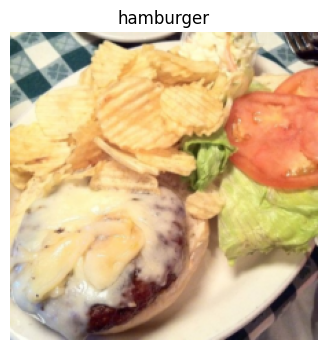

In [ ]:
img_batch, label_batch = next(iter(train_dataloader))

img, label = img_batch[0], label_batch[0]

plt.figure(figsize=(6, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_names[label]}")
plt.axis(False);

### 1.3 Patchfy images

patch resolution = 16 $\times$ 16

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

assert (height * width) % (patch_size**2) == 0, "Image resolution must be divisible by patch size"

patch_num = (height * width) // (patch_size ** 2)
patch_num

196

In [ ]:
permuted_image = img.permute(1, 2, 0)
permuted_image.shape

torch.Size([224, 224, 3])

<Figure size 1000x600 with 0 Axes>

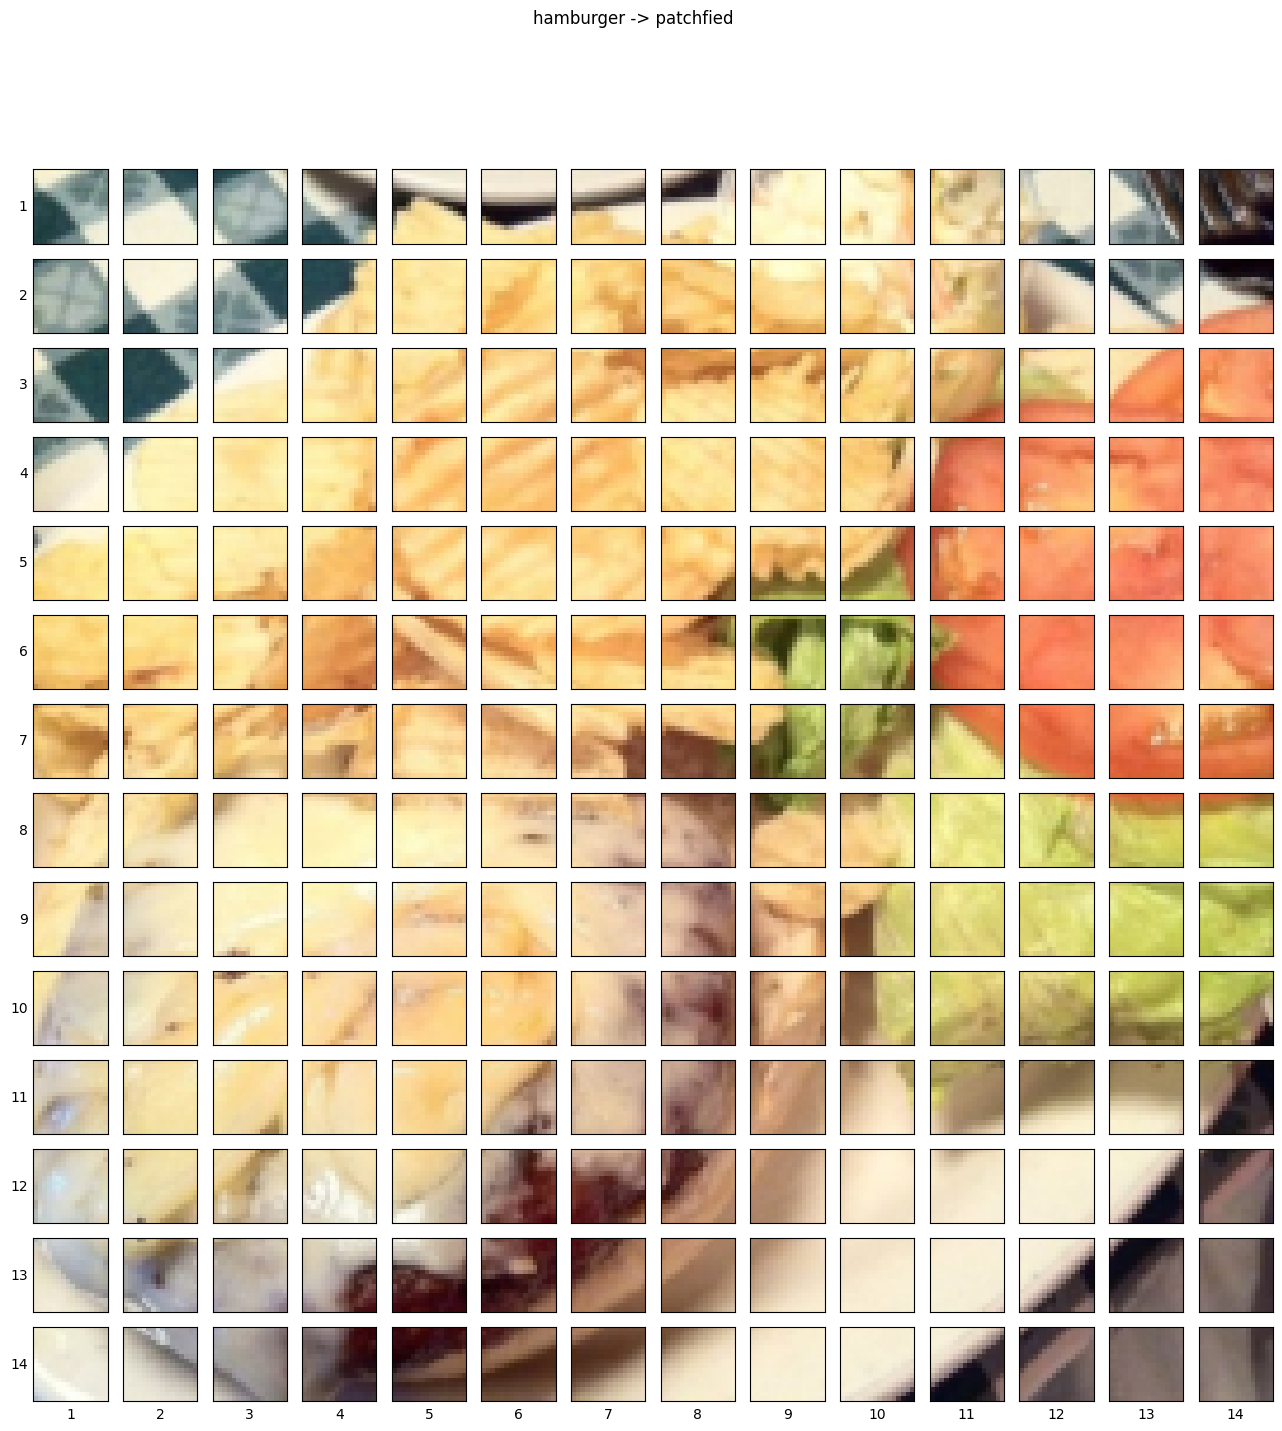

In [ ]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=width // patch_size,
                         ncols=height // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

for i, patch_i in enumerate(range(0, height, patch_size)):
  for j, patch_j in enumerate(range(0, width, patch_size)):
    axes[i,j].imshow(permuted_image[patch_i:patch_i+patch_size, patch_j:patch_j+patch_size, :])
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i,j].set_xlabel(j+1)
    axes[i,j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axes[i,j].label_outer()

fig.suptitle(f"{class_names[label]} -> patchfied")
plt.show();

### 1.4 Creates patch embedding via Conv2d

See the section 3.1:

"The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings."

Eq. 1:

$ z_0 = [x_{class}; x_{p}^{1} E; x_{p}^{2} E; ...; x_{p}^{N} E] + E_{pos}$

As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1x1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

#### step-by-step

1. **Input image**
> Shape $(B, C, H, W)$ -> (batch_size, color_channels, height, width)

2. **Conv2d for patch feature extractions**
> Use a `Conv2d` layer with:
> - in_channels = C
> - out_channels = D (embedding dimension (hidden size D) from Table 1)
> - kernal_size = P
> - stride = P
> - padding = 0
> Resulting feature map shape $(B, D, H/P, W/P)$ -> (batch_size, embedding_dimension, patch_num_height, patch_num_width)

3. **Flatten to sequence**
> - Flatten spatial dimensions: $(B, D, N)$, where $N = HW/P^2$
> - Transpose to $(B, N, D)$ for Transformer input.


**Key:** convert image into *learnable and flattened* embedding



In [ ]:
# Model = ViT-BASE
# Redefine hyper parameters, Table 1 and Table 3
color_channel = 3
height = 224
width = 224
embedding_dimension = 768
patch_size = 16
patch_num = (height * width) // (patch_size ** 2)
batch_size = 32

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=16,
                   stride=16,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# check the resulting dimension is what we wanted
img_batch, label_batch = next(iter(train_dataloader))
single_image, label = img_batch[0].unsqueeze(dim=0), class_names[label_batch[0]]

In [ ]:
after_conv2d = conv2d(single_image)

after_conv2d.shape, after_conv2d.shape == torch.Size([1, embedding_dimension, height // patch_size, width // patch_size])

(torch.Size([1, 768, 14, 14]), True)

In [ ]:
flatten_after_conv2d = after_conv2d.flatten(start_dim=2,
                                            end_dim=3).permute(0, 2, 1)
flatten_after_conv2d.shape

torch.Size([1, 196, 768])

### 1.5 Prepend class embedding

See section 3.1:

We prepend a learnable embedding to sequence of embeded patches, whose state at the output of the Transformer encoder serves as the image representation y.

In [ ]:
# just visualization purpose, later we will change it into random
class_embedding = nn.Parameter(torch.ones(1, 1, embedding_dimension))

In [ ]:
class_patch_embedding = torch.cat((class_embedding, flatten_after_conv2d), dim=1)
class_patch_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
class_patch_embedding # you will see ones are prepended

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9357, -0.3478, -1.0941,  ..., -0.3090, -0.0460, -0.3003],
         [ 0.8242, -0.3950, -0.8717,  ..., -0.2691, -0.0181, -0.2667],
         ...,
         [ 0.9485, -0.4261, -1.0003,  ..., -0.3845, -0.1031, -0.3431],
         [ 1.0654, -0.5491, -1.1966,  ..., -0.3268, -0.0350, -0.3899],
         [ 0.8168, -0.5626, -1.0938,  ..., -0.1759,  0.0829, -0.3675]]],
       grad_fn=<CatBackward0>)

### 1.6 Add Position embeddings
See Section 3.1:

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In [ ]:
# just visualization purpose, later we will change it into random
position_embedding = nn.Parameter(torch.ones(1, class_patch_embedding.shape[1], embedding_dimension))

class_patch_position_embedding = class_patch_embedding + position_embedding
class_patch_position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
class_patch_position_embedding # you have added ones everywhere

tensor([[[ 2.0000e+00,  2.0000e+00,  2.0000e+00,  ...,  2.0000e+00,
           2.0000e+00,  2.0000e+00],
         [ 1.9357e+00,  6.5219e-01, -9.4106e-02,  ...,  6.9104e-01,
           9.5399e-01,  6.9974e-01],
         [ 1.8242e+00,  6.0504e-01,  1.2833e-01,  ...,  7.3085e-01,
           9.8188e-01,  7.3325e-01],
         ...,
         [ 1.9485e+00,  5.7388e-01, -2.9898e-04,  ...,  6.1550e-01,
           8.9692e-01,  6.5690e-01],
         [ 2.0654e+00,  4.5091e-01, -1.9655e-01,  ...,  6.7321e-01,
           9.6501e-01,  6.1009e-01],
         [ 1.8168e+00,  4.3741e-01, -9.3785e-02,  ...,  8.2412e-01,
           1.0829e+00,  6.3247e-01]]], grad_fn=<AddBackward0>)

### 1.7 Visualize flattened feature map

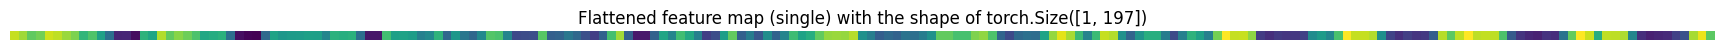

In [ ]:
feature_map = class_patch_position_embedding.permute(0, 2, 1)[:, 0, :]
plt.figure(figsize=(22, 22))
plt.imshow(feature_map.detach().numpy())
plt.title(f"Flattened feature map (single) with the shape of {feature_map.shape}")
plt.axis('off')
plt.show();

### 1.8 Putting it all together (Equation 1)

The output of this step serves as the input to the Transformer Encoder (Equation 2 and 3)

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               input_shape: int=3,
               embedding_dimension: int=768,
               patch_size: int=16):
    super().__init__()

    self.patch_size = patch_size
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=embedding_dimension,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0),
        nn.Flatten(start_dim=2,
                   end_dim=3)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, "Image resolution must be divisible by patch size"

    flattened_x = self.layer(x)
    return flattened_x.permute(0, 2, 1)

In [ ]:
# Set seeds
set_seeds(42)

# Redefine everything
color_channels = 3
height = 224
width = 224
patch_size = 16
patch_num = (height * width) // (patch_size ** 2)
embedding_dimension = 768

# Get single image tensor and corresponding label as an example run
img_batch, label_batch = next(iter(train_dataloader))
X, y = img_batch[0].unsqueeze(dim=0), class_names[label_batch[0]]

# Define patch embedding layer
patch_embedding_layer = PatchEmbedding(input_shape=color_channels,
                                       embedding_dimension=embedding_dimension,
                                       patch_size=patch_size)

# Pass image tensor through patch_embedding_layer
patch_embedding = patch_embedding_layer(X)
batch_size = patch_embedding.shape[0]
print(f"Output shape of patch_embedding_layer: {patch_embedding.shape}")

# Create class token and prepend it to patch embedding
class_embedding = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension)) # change it to random later
class_patch_embedding = torch.cat((class_embedding, patch_embedding), dim=1)
print(f"Ouput shape of patch embedding with class token: {class_patch_embedding.shape}")

# Create position embedding and add it to class_patch_embedding
position_embedding = nn.Parameter(torch.ones(batch_size, patch_num + 1, embedding_dimension)) # change it to random later
class_patch_position_embedding = class_patch_embedding + position_embedding
print(f"Ouput shape of patch embedding with class token and position embedding: {class_patch_position_embedding.shape}")

class_patch_position_embedding

Output shape of patch_embedding_layer: torch.Size([1, 196, 768])
Ouput shape of patch embedding with class token: torch.Size([1, 197, 768])
Ouput shape of patch embedding with class token and position embedding: torch.Size([1, 197, 768])


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3993, 1.1462, 1.0186,  ..., 1.2563, 0.8196, 1.1310],
         [0.7632, 1.0609, 0.8547,  ..., 1.2582, 0.9081, 1.0541],
         ...,
         [0.8287, 1.0269, 0.8474,  ..., 1.4404, 0.8650, 1.0080],
         [0.8426, 0.9744, 0.9156,  ..., 1.1505, 0.9684, 1.0907],
         [0.8678, 1.0359, 0.9424,  ..., 1.1281, 0.9458, 1.0123]]],
       grad_fn=<AddBackward0>)

## 2. Transformer Encoder

### 2.1 Multiheaded Self-Attention (MSA) Block (Equation 2)

See. Appendix A

** Equation 2 **
$z_{l}^{\prime} = MSA(LN(z_{l-1})) + z_{l-1}$

** Multihead self-attension **

Standard **qkv** self-attention (SA) is a popular building block for neural architectures.

For each element in an input sequence $z$, we compute a weighted sum over all values **v** in the sequence.

The attention weights $A_{ij}$ are based on the pairwise similarity between two elements of the sequence and their respective query $q^{i}$ and key $k^{j}$ representations.

$[q, k, v] = z U_{qkv}$

$A = softmax(qk^{\dagger} / \sqrt{D_{h}})$

$SA(z) = Av$

$MSA(z) = [SA_1(z); SA_2(z);...; SA_{k}(Z)]U_{msa}$

https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

In [ ]:
class MSABlock(nn.Module):
  def __init__(self,
               embedding_dimension: int = 768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads: int = 12, # Heads from Table 1 for ViT-Base
               attn_dropout: int=0):
    super().__init__()

    # Create a Layer Norm (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

    # Create a Multihead Attention layer
    self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, num_patches, embedding_dim)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.layer_norm(x)
    attn_output, attn_output_weights = self.multihead_attention(query=x,
                                                                key=x,
                                                                value=x,
                                                                need_weights=False)
    return attn_output

In [ ]:
msa = MSABlock(embedding_dimension=embedding_dimension,
               num_heads=12, # from Table 1 Heads for ViT-Base
               attn_dropout=0) # Table 3

patch_embedding_through_msa = msa(class_patch_position_embedding)

print(f"Input shape of MSA block: {class_patch_position_embedding.shape}")
print(f"Output shape of MSA block: {patch_embedding_through_msa.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
class_patch_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3993, 1.1462, 1.0186,  ..., 1.2563, 0.8196, 1.1310],
         [0.7632, 1.0609, 0.8547,  ..., 1.2582, 0.9081, 1.0541],
         ...,
         [0.8287, 1.0269, 0.8474,  ..., 1.4404, 0.8650, 1.0080],
         [0.8426, 0.9744, 0.9156,  ..., 1.1505, 0.9684, 1.0907],
         [0.8678, 1.0359, 0.9424,  ..., 1.1281, 0.9458, 1.0123]]],
       grad_fn=<AddBackward0>)

In [ ]:
patch_embedding_through_msa

tensor([[[-5.5761e-01,  3.8175e-01, -6.6828e-02,  ...,  6.1276e-03,
          -1.5678e-01,  5.2704e-02],
         [-5.3068e-01,  3.8661e-01, -5.4443e-02,  ...,  5.0516e-03,
          -1.6879e-01,  6.0610e-02],
         [-5.3300e-01,  3.6857e-01, -5.3095e-02,  ...,  7.0265e-03,
          -1.6841e-01,  6.0458e-02],
         ...,
         [-5.2751e-01,  3.7217e-01, -4.6125e-02,  ..., -2.9480e-04,
          -1.7442e-01,  5.3075e-02],
         [-5.3352e-01,  3.6911e-01, -6.0503e-02,  ...,  1.0675e-02,
          -1.6719e-01,  5.7883e-02],
         [-5.3263e-01,  3.6936e-01, -4.8837e-02,  ...,  5.9923e-03,
          -1.6570e-01,  6.0644e-02]]], grad_fn=<TransposeBackward0>)